In [ ]:
# --- 0. Install Libraries (and fix potential NumPy 2.0 issues) ---
# Downgrading NumPy to avoid errors with TensorFlow/OpenCV in some environments
!pip install numpy==1.26.4
!pip install tensorflow keras matplotlib opencv-python

# --- IMPORTANT ---
# After these installs finish, you MUST restart your kernel/runtime.
# In Jupyter/VS Code: Kernel -> Restart
# In Google Colab: Runtime -> Restart runtime
# Then, re-run this entire cell.
# -----------------



  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<

  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 # For loading the prediction image

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)



TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
# --- 1. Define Settings ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 25 # You can increase this for better accuracy if needed

# --- 2. Load the Built-in Dataset (Automatic Download) ---
print("Downloading and preparing 'cats_and_dogs_filtered' dataset...")
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# get_file downloads and extracts the data
dataset_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Find the folder where the images were unzipped
# Sometimes it's directly 'cats_and_dogs_filtered', sometimes it's inside another folder
base_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered')
# If the direct path doesn't exist, try the path inside '_extracted'
if not os.path.exists(base_dir):
     base_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered_extracted', 'cats_and_dogs_filtered')

# Set the paths to the training and validation image folders
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

print("Training images are in:", train_dir)
print("Validation images are in:", validation_dir)



Training images are in: /root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered/train
Validation images are in: /root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered/validation


In [ ]:
# --- 3. Prepare the Image Data ---
print("Setting up image loaders (generators)...")
# ImageDataGenerator can do things like resizing and rescaling pixels
# We rescale pixel values from 0-255 to 0-1 because models like smaller numbers
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Tell the generators where to find the images and how to load them
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,            # Folder with training images
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to our set size
    batch_size=BATCH_SIZE,          # Load images in batches
    class_mode='binary'             # It's 'binary' because we have 2 classes (cat/dog)
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,         # Folder with validation images
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



Setting up image loaders (generators)...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# --- 4. Build the Neural Network (CNN Model) ---
print("Building the neural network model...")
# We use a 'Sequential' model, meaning layers are stacked one after another
model = keras.Sequential([
    # Input Layer: Tells the model the shape of our images (height, width, color channels)
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Convolutional Layer 1: Finds basic patterns (edges, corners)
    # 32 filters, 3x3 kernel size, 'relu' activation function
    layers.Conv2D(32, (3, 3), activation='relu'),
    # Pooling Layer 1: Shrinks the image size, keeps important info
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2: Finds more complex patterns
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Pooling Layer 2: Shrinks again
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3: Finds even more complex patterns
    layers.Conv2D(128, (3, 3), activation='relu'),
    # Pooling Layer 3: Shrinks again
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer: Converts the 2D image features into a 1D list
    layers.Flatten(),

    # Dense Layer (Fully Connected): Like a standard neural network layer
    layers.Dense(512, activation='relu'), # 512 neurons

    # Output Layer: Final decision layer
    # 1 neuron because it's cat OR dog (binary)
    # 'sigmoid' activation gives a probability between 0 (cat) and 1 (dog)
    layers.Dense(1, activation='sigmoid')
])



Building the neural network model...


Compiling the model (getting it ready for training)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5124 - loss: 1.0928 - val_accuracy: 0.6080 - val_loss: 0.6919
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5708 - loss: 0.6929 - val_accuracy: 0.5690 - val_loss: 0.6725
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6286 - loss: 0.6507 - val_accuracy: 0.5700 - val_loss: 0.6791
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6738 - loss: 0.5907 - val_accuracy: 0.6310 - val_loss: 0.6872
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7430 - loss: 0.5141 - val_accuracy: 0.6710 - val_loss: 0.6595
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8327 - loss: 0.3590 - val_accuracy: 0.6970 - val_loss: 0.6658
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8687 - loss: 0.2798 - val_accuracy: 0.7000 - val_loss: 0.8396
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9237 - loss: 0.1888 - val_accuracy: 0.6680 - v

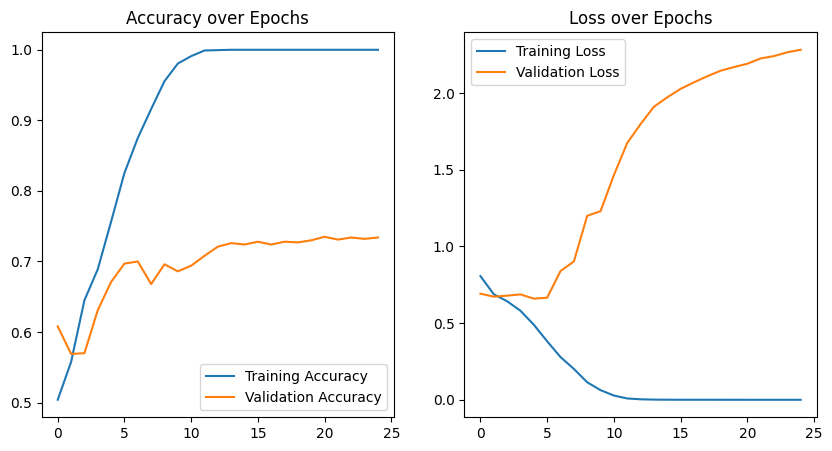

In [ ]:
# --- 5. Compile the Model ---
print("Compiling the model (getting it ready for training)...")
model.compile(
    optimizer='adam', # 'adam' is a popular algorithm for updating the model
    loss='binary_crossentropy', # Measures how wrong the predictions are (good for cat/dog)
    metrics=['accuracy'] # We want to track the accuracy during training
)

# Show a summary of the layers in our model
model.summary()

# --- 6. Train the Model ---
print("\nStarting training...")
# 'fit' starts the training process
history = model.fit(
    train_data_gen, # Use the generator for training data
    steps_per_epoch=len(train_data_gen), # How many batches make one full pass (epoch)
    epochs=EPOCHS, # How many full passes over the data
    validation_data=val_data_gen, # Use the generator for validation data
    validation_steps=len(val_data_gen) # How many batches for validation
)
print("Training finished!")

# --- 7. Show Training Results ---
# Get the accuracy and loss values recorded during training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS) # Creates numbers 0, 1, 2... up to EPOCHS-1

# Create a figure to hold the plots
plt.figure(figsize=(10, 5))

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 1) # Position for the first plot (1 row, 2 columns, 1st plot)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend() # Show the labels ('Training Accuracy', 'Validation Accuracy')
plt.title('Accuracy over Epochs')

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2) # Position for the second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

# Display the plots
plt.show()




Making predictions for 1 images...
--- Predicting: download.jpeg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Result: Likely a dogs (Confidence: 1.00)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


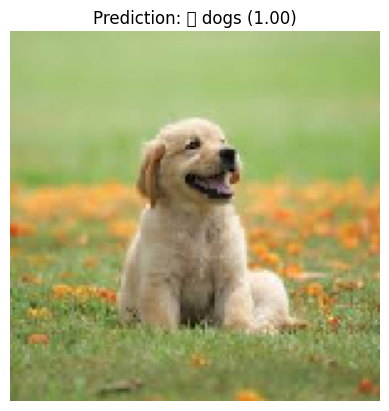

------------------------------


In [ ]:
# --- 8. Predict on Multiple Sample Images ---

image_paths_to_predict = [r"/content/download.jpeg"]

# Check if the list has any paths
if image_paths_to_predict:
    print(f"\nMaking predictions for {len(image_paths_to_predict)} images...")

    # Loop through each image path in the list
    for img_path in image_paths_to_predict:
        if os.path.exists(img_path):
            print(f"--- Predicting: {os.path.basename(img_path)} ---") # Show just the file name

            # Load and preprocess the image (same steps as before)
            img = keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = keras.utils.img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict using the trained model
            prediction = model.predict(img_array)
            score = prediction[0][0]

            # Get the class names like before
            class_names = list(train_data_gen.class_indices.keys())

            # --- Display the image and prediction ---
            plt.figure() # Create a new figure for each image
            plt.imshow(img)
            plt.axis('off')

            if score > 0.5:
                print(f"Result: Likely a {class_names[1]} (Confidence: {score:.2f})")
                plt.title(f"Prediction: 🐶 {class_names[1]} ({score:.2f})")
            else:
                print(f"Result: Likely a {class_names[0]} (Confidence: {1 - score:.2f})")
                plt.title(f"Prediction: 🐱 {class_names[0]} ({1 - score:.2f})")

            plt.show() # Show the plot for this image
            print("-" * 30) # Separator line

        else:
            # If a path in the list is wrong, print a warning
            print(f"\nWarning: Image path not found, skipping: {img_path}")
            print("-" * 30)

else:
    # If the list is empty, print this message
    print("\nSkipping predictions.")
    print("Please add image file paths to the 'image_paths_to_predict' list and re-run section 8.")